In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from torchvision import transforms
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pytesseract import image_to_string

In [3]:
class MaskDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return (self.images[idx], self.masks[idx])

In [4]:
dataset = torch.load('/kaggle/input/iam-forms-masks/mask_dataset.pt')

In [5]:
from torch.utils.data import random_split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the dataset lengths
total_length = len(dataset)
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length

# Split the dataset into train, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_length, val_length, test_length])

In [6]:
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [7]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(dropout_rate)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        return x

In [8]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvolutionBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        x = self.conv(x)
        output = self.pool(x)
        return x, output

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2,
            padding=0
        )

        self.conv = ConvolutionBlock(in_channels + out_channels, out_channels, dropout_rate)

    def forward(self, x, skip_connection):
        x = self.conv_transpose(x)
        x = torch.cat([x, skip_connection], axis=1)
        x = self.conv(x)

        return x

In [30]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.enc1 = EncoderBlock(1, 16)
        self.enc2 = EncoderBlock(16, 32)
        self.enc3 = EncoderBlock(32, 64)
        
        self.dec1 = DecoderBlock(64, 32)
        self.dec2 = DecoderBlock(32, 16)
        self.dec3 = DecoderBlock(16, 1)
        
    def forward(self, x):
        skip_conn1, x = self.enc1(x)
        skip_conn2, x = self.enc2(x)
        skip_conn3, x = self.enc3(x)

        x = self.dec1(x, skip_conn3)
        x = self.dec2(x, skip_conn2)
        x = self.dec3(x, skip_conn1)
        
        return x

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
model = UNet().to(device)

In [41]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

In [ ]:
import time

num_epochs = 100
train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = F.interpolate(images, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)
        masks = F.interpolate(masks, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        torch.cuda.empty_cache()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}', end=', ')

    unet.eval()
    val_loss = 0.0
    for val_images, val_masks in val_loader:
        val_images = F.interpolate(val_images, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)
        val_masks = F.interpolate(val_masks, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)

        with torch.no_grad():
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_masks).item()
            
        torch.cuda.empty_cache()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}, Time taken : {int(time.time() - start_time)} s')
    start_time = time.time()
    unet.train()

Epoch [1/100], Training Loss: 0.8664, Validation Loss: 0.8490, Time taken : 109 s
Epoch [2/100], Training Loss: 0.8753, Validation Loss: 0.8574, Time taken : 108 s
Epoch [3/100], Training Loss: 0.8705, Validation Loss: 0.8557, Time taken : 108 s
Epoch [4/100], Training Loss: 0.8663, Validation Loss: 0.8623, Time taken : 110 s
Epoch [5/100], Training Loss: 0.8616, Validation Loss: 0.8705, Time taken : 109 s
Epoch [6/100], Training Loss: 0.8692, Validation Loss: 0.8420, Time taken : 110 s


In [12]:
unet = UNet(num_classes=1).to(device)

In [16]:
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = F.interpolate(images, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)
        masks = F.interpolate(masks, size=(1024, 1024), mode='bilinear', align_corners=False)
        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3]).to(device)

        optimizer.zero_grad()
        outputs = unet(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        torch.cuda.empty_cache()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}', end=', ')

    unet.eval()
    val_loss = 0.0
    for val_images, val_masks in val_loader:
        val_images = F.interpolate(val_images, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)
        val_masks = F.interpolate(val_masks, size=(1024, 1024), mode='bilinear', align_corners=False)
        val_masks = val_masks.reshape(val_masks.shape[0], val_masks.shape[2], val_masks.shape[3]).to(device)

        with torch.no_grad():
            val_outputs = unet(val_images)
            val_loss += criterion(val_outputs, val_masks).item()
            
        torch.cuda.empty_cache()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')
    unet.train()

Epoch [1/100], Training Loss: 0.2797, Validation Loss: 0.1573
Epoch [2/100], Training Loss: 0.2388, Validation Loss: 0.1464
Epoch [3/100], Training Loss: 0.2365, Validation Loss: 0.1391
Epoch [4/100], Training Loss: 0.2433, Validation Loss: 0.1447
Epoch [5/100], Training Loss: 0.2355, Validation Loss: 0.1371
Epoch [6/100], Training Loss: 0.2456, Validation Loss: 0.1383
Epoch [7/100], Training Loss: 0.2375, Validation Loss: 0.1385
Epoch [8/100], Training Loss: 0.2352, Validation Loss: 0.1568
Epoch [9/100], Training Loss: 0.2264, Validation Loss: 0.1412
Epoch [10/100], Training Loss: 0.2340, Validation Loss: 0.1317
Epoch [11/100], Training Loss: 0.2299, Validation Loss: 0.1330
Epoch [12/100], Training Loss: 0.2345, Validation Loss: 0.1366
Epoch [13/100], Training Loss: 0.2303, Validation Loss: 0.1349
Epoch [14/100], Training Loss: 0.2257, Validation Loss: 0.1259
Epoch [15/100], Training Loss: 0.2348, Validation Loss: 0.1298
Epoch [16/100], Training Loss: 0.2273, Validation Loss: 0.1372
E

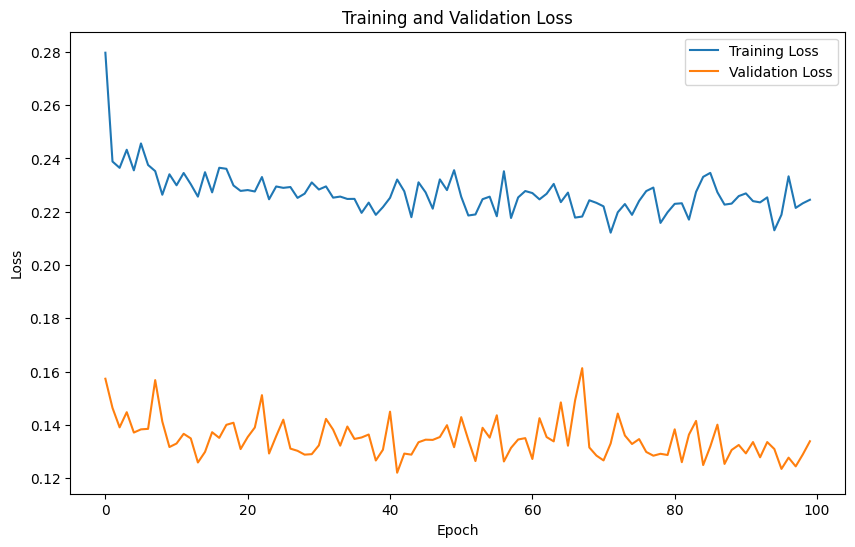

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [18]:
torch.save(unet, 'unet_mse.pth')

In [19]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'unet_mse.pth')

/kaggle/working


/kaggle/working/unet_mse.pth

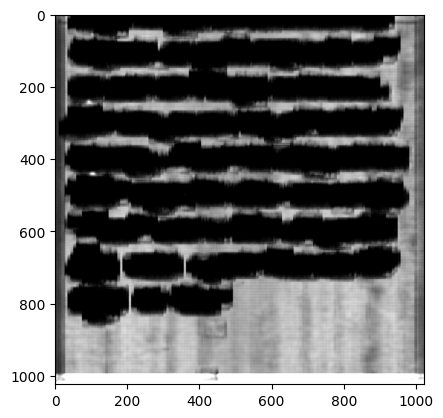

In [29]:
for images, labels in train_loader:
    images = F.interpolate(images, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)
    channel1, channel2 = unet(images).squeeze()
    plt.imshow(channel2.detach().cpu(), cmap=plt.cm.binary)
    plt.show()
    break